<img src="https://thevalley.es/wp-content/uploads/2016/11/thevalley-logo-negro.png" width="400"></img>

# Aplicación networkX - Sistema de recomendación

A veces el análisis de grafos nos permite construir modelos más sencillos pero sobre un modelo de información complejo. En este caso vamos a construir un sistema de recomendación de películas basada en un modelo de grafos.

<img src="https://miro.medium.com/max/644/1*N0-ikjPv4RUVvS-6KCgLPg.jpeg" width="500"></img>

<img src="https://networkx.org/_static/networkx_logo.svg" width="200"></img>


El propósito es construir un motor de recomendación basado en un gráfico utilizando la medida Adamic Adar.

Documentación de la librería: https://networkx.github.io/

**Notebook por: David Rey**

## Carga de librerías

In [ ]:
#
# Carga de librerías
#
%matplotlib inline
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math as math
from matplotlib.pyplot import figure
import time
plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = [14,14]

## Carga de datos

In [ ]:
#
# Cargamos los datos
#
url = 'https://github.com/davidreyblanco/ml-training/raw/master/data/recommender/netflix_titles.csv.gz'
df = pd.read_csv(url)

In [ ]:
#
# Vemos los primeros registros
#
df.head(3)

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,TV Show,3%,NaN,"João Miguel, Bianca Comparato, Michel Gomes, R...",Brazil,"August 14, 2020",2020,TV-MA,4 Seasons,"International TV Shows, TV Dramas, TV Sci-Fi &...",In a future where the elite inhabit an island ...
1,s2,Movie,7:19,Jorge Michel Grau,"Demián Bichir, Héctor Bonilla, Oscar Serrano, ...",Mexico,"December 23, 2016",2016,TV-MA,93 min,"Dramas, International Movies",After a devastating earthquake hits Mexico Cit...
2,s3,Movie,23:59,Gilbert Chan,"Tedd Chan, Stella Chung, Henley Hii, Lawrence ...",Singapore,"December 20, 2018",2011,R,78 min,"Horror Movies, International Movies","When an army recruit is found dead, his fellow..."


In [ ]:
#
# Realizamos algunas conversiones sobre los datos
#
df["date_added"] = pd.to_datetime(df['date_added'])
df['year'] = df['date_added'].dt.year
df['month'] = df['date_added'].dt.month
df['day'] = df['date_added'].dt.day

#
# convertimos las columnas "director, listerd_in, cast y country" en columnas que contienen una lista
# la función strip se aplica a los elementos usando el separador ','
# si el valor es NaN, la nueva columna contiene una lista vacía []
#
df['directors'] = df['director'].apply(lambda l: [] if pd.isna(l) else [i.strip() for i in l.split(",")])
df['categories'] = df['listed_in'].apply(lambda l: [] if pd.isna(l) else [i.strip() for i in l.split(",")])
df['actors'] = df['cast'].apply(lambda l: [] if pd.isna(l) else [i.strip() for i in l.split(",")])
df['countries'] = df['country'].apply(lambda l: [] if pd.isna(l) else [i.strip() for i in l.split(",")])

df.head(3)

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,year,month,day,directors,categories,actors,countries
0,s1,TV Show,3%,NaN,"João Miguel, Bianca Comparato, Michel Gomes, R...",Brazil,2020-08-14,2020,TV-MA,4 Seasons,"International TV Shows, TV Dramas, TV Sci-Fi &...",In a future where the elite inhabit an island ...,2020.0,8.0,14.0,[],"[International TV Shows, TV Dramas, TV Sci-Fi ...","[João Miguel, Bianca Comparato, Michel Gomes, ...",[Brazil]
1,s2,Movie,7:19,Jorge Michel Grau,"Demián Bichir, Héctor Bonilla, Oscar Serrano, ...",Mexico,2016-12-23,2016,TV-MA,93 min,"Dramas, International Movies",After a devastating earthquake hits Mexico Cit...,2016.0,12.0,23.0,[Jorge Michel Grau],"[Dramas, International Movies]","[Demián Bichir, Héctor Bonilla, Oscar Serrano,...",[Mexico]
2,s3,Movie,23:59,Gilbert Chan,"Tedd Chan, Stella Chung, Henley Hii, Lawrence ...",Singapore,2018-12-20,2011,R,78 min,"Horror Movies, International Movies","When an army recruit is found dead, his fellow...",2018.0,12.0,20.0,[Gilbert Chan],"[Horror Movies, International Movies]","[Tedd Chan, Stella Chung, Henley Hii, Lawrence...",[Singapore]


In [ ]:
#
# Vemos el número de filas, y columnas del data frame
#
df.shape

(7787, 19)

## Similitudes en texto

### Cálculo de las medidas de similitud en descripciones

**Tf-idf** (del inglés Term frequency – Inverse document frequency), frecuencia de término – frecuencia inversa de documento (o sea, la frecuencia de ocurrencia del término en la colección de documentos), es una medida numérica que expresa cuán relevante es una palabra para un documento en una colección.

Se compone de dos elementos, el primero el **tf** es la frecuencia del término t en el documento d:

$$
tf(t,d) = \frac{f(t,d)}{max\ \{ f(t,d) : t \in \ d\}}
$$

Y el segundo la frecuencia inversa **idf**, se obtiene dividiendo el número total de documentos por el número de documentos que contienen el término, y se toma el logaritmo de ese cociente:

$$
idf(t,D) = log \frac{|D|}{|\{d \in D : t \in d\}|}
$$

Donde $|D|$ es la cardinalidad de D, es decir el número de documentos en la colección.

Por tanto el *idf* se calculará como el producto de ambos:

$$
tf\_idf(t,d,D) = tf(t,d) \times idf(t,D)
$$

Esta medida se utiliza a menudo como un factor de ponderación en la recuperación de información y la minería de texto. El valor tf-idf aumenta proporcionalmente al número de veces que una palabra aparece en el documento, pero es compensada por la frecuencia de la palabra en la colección de documentos, lo que permite manejar el hecho de que algunas palabras son generalmente más comunes que otras.

Referencias:

* [Referencia TF-Idf](https://es.wikipedia.org/wiki/Tf-idf)
* [Función tfidf de scikitlearn](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html)


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn.cluster import MiniBatchKMeans

# Construimos la matriz de tf-idf con las descripciones
start_time = time.time()
text_content = df['description']
vector = TfidfVectorizer(max_df = 0.4,         # eliminar las palabras que aparecen en más del X por ciento de los documentos
                             min_df = 1,      # solo palabras que aparezcan al menos 1 vez
                             stop_words = 'english', # Eliminamos palabras de parada
                             lowercase = True, # Convertimos todo a minúsculas
                             use_idf = True,   # Usamos idf
                             norm = u'l2',     # Tipo de normalización
                             smooth_idf=True   # Evita errores de división por cero
                            )
tfidf = vector.fit_transform(text_content)

In [ ]:
#
# La matriz contiene una fila por cada película y una columna por cada término
#
tfidf.shape

(7787, 17905)

In [ ]:
#
# La matriz es dispersa, casi todos sus elementos son ceros
#
tfidf[1:10,1:10].todense()

matrix([[0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.]])

Creamos una función que sobre la matriz original devuelve **top_n** películas más parecidas en base a la **similitud coseno** (es decir la medida normalizada de que palabras comparten las descripciones de ambas películas).

Nota:*en realidad sería sobre los tfidf*.

In [ ]:
#
# find_similar: devuelve el top_n de las películas una descripción similar a la descripción del objetivo
#
def find_similar(tfidf_matrix, index, top_n = 5):
    cosine_similarities = linear_kernel(tfidf_matrix[index:index+1], tfidf_matrix).flatten()
    related_docs_indices = [i for i in cosine_similarities.argsort()[::-1] if i != index]
    return [index for index in related_docs_indices][0:top_n]

### Creación de clusters de películas

En este caso vamos a construir un modelo de k medias como etiqueta de clasificación en base al contenido de texto. En este caso usaremos 30 grupos.

In [ ]:
k = 10
kmeans = MiniBatchKMeans(n_clusters = k)
kmeans.fit(tfidf)
centers = kmeans.cluster_centers_.argsort()[:,::-1]
terms = vector.get_feature_names()

request_transform = vector.transform(df['description'])
# new column cluster based on the description
df['cluster'] = kmeans.predict(request_transform)
# Clustering  Kmeans
df['cluster'].value_counts().head()

1    6564
4     501
3     427
7     289
6       1
Name: cluster, dtype: int64

**pregunta** ¿cómo es de sensible nuestro clustering de películas ante el tamaño de k?, ¿es determinista (es decir en cada ejecución genera los mismos grupos?

Mostramos los centroides de los 3 primeros grupos creados automáticamente

In [ ]:
for i in range(0,3):
     word_list=[]
     print("grupo %d:"% i)
     for j in centers[i,:10]:
         word_list.append(terms[j])
     print(word_list)

grupo 0:
['bundy', 'liz', 'ted', 'refuses', 'believe', 'crimes', 'truth', 'single', 'drama', 'based']
grupo 1:
['life', 'new', 'world', 'young', 'man', 'love', 'friends', 'series', 'documentary', 'lives']
grupo 2:
['drumming', 'somethings', 'pursuits', 'artistic', '20', 'dancer', 'talented', 'lead', 'singer', 'aspiring']


El clúster de columnas no se utilizará porque los clústeres son dos
Pero se utilizará tfidf para encontrar una descripción similar

## Construcción del grafo

Construiremos un grafo no dirigido, en este caso no existirán relaciones directas entre películas sino serán entre otros nodos (el caso de la similitud es un nodo artificial que conecta a las películas en base a su similitud'.

Los **vértices** serán estos objetos:

* Películas
* Persona ( actor o director)
* Categoría
* País
* Cluster (descripción)
* Sim(título) top 5 más similares usando la descripción

Las aristas serán:

* **ACTED_IN**: relación entre un actor y una película
* **CAT_IN**: relación entre una categoría y una película
* **DIRECTED**: relación entre un director y una película
* **COU_IN**: relación entre un país y una película
* **DESCRIPTION**: relación entre un clúster y una película
* **SIMILARITY** en el sentido de la descripción

Por lo tanto, dos películas no están conectadas directamente, pero comparten personas, categorías, grupos o países.

### Construcción del grafo

In [ ]:
#
# Creamos el grafo no dirigido
#
G = nx.Graph(label="MOVIE")

start_time = time.time()

for i, rowi in df.iterrows():
    if (i % 1000 == 0):
        print(" iteración {} -- {} segundos --".format(i,time.time() - start_time))

    #
    # Creamos un nodo película
    #
    G.add_node(rowi['title'],
               key=rowi['show_id'],
               label="MOVIE",
               mtype=rowi['type'],
               rating=rowi['rating'])

    #
    # Añadimos la relación por cluster
    #
    G.add_node(rowi['cluster'],label="CLUSTER")
    G.add_edge(rowi['title'], rowi['cluster'], label="DESCRIPTION")

    #
    # Construimos los nodos y relaciones para cada elemento
    #
    for element in rowi['actors']:
        G.add_node(element,label="PERSON")
        G.add_edge(rowi['title'], element, label="ACTED_IN")
    for element in rowi['categories']:
        G.add_node(element,label="CAT")
        G.add_edge(rowi['title'], element, label="CAT_IN")
    for element in rowi['directors']:
        G.add_node(element,label="PERSON")
        G.add_edge(rowi['title'], element, label="DIRECTED")
    for element in rowi['countries']:
        G.add_node(element,label="COU")
        G.add_edge(rowi['title'], element, label="COU_IN")

    #
    # Finalmente construimos las relaciones por similitud
    # en este caso tomamos 5 elementos
    #
    indices = find_similar(tfidf, i, top_n = 5)
    snode="Sim(" + rowi['title'][:15].strip()+")"
    G.add_node(snode,label="SIMILAR")
    G.add_edge(rowi['title'], snode, label="SIMILARITY")
    for element in indices:
        G.add_edge(snode, df['title'].loc[element], label="SIMILARITY")

print(" Total tiempo -- {} segundos --".format(time.time() - start_time))

 iteración 0 -- 0.03360271453857422 segundos --
 iteración 1000 -- 6.644326210021973 segundos --
 iteración 2000 -- 13.166414976119995 segundos --
 iteración 3000 -- 19.78076696395874 segundos --
 iteración 4000 -- 26.394609451293945 segundos --
 iteración 5000 -- 32.977240324020386 segundos --
 iteración 6000 -- 39.713430881500244 segundos --
 iteración 7000 -- 46.53392314910889 segundos --
 Total tiempo -- 51.77932620048523 segundos --


## Creación de utilidades

### Selección de subgrafos

Crearemos una función que devuelve todos los nodos adyacentes a una lista, la usaremos para buscar películas parecidas a las de una lista dada (en realidad usaremos dos como entrada y buscaremos su vecindario nodos compartidos).

[Referencia](https://networkx.org/documentation/stable/reference/classes/generated/networkx.Graph.neighbors.html)

In [ ]:
#
# Función que devuelve todos los nodos adyacentes a una lista
#
def get_all_adj_nodes(list_in):
    sub_graph=set()
    for m in list_in:
        sub_graph.add(m)
        for e in G.neighbors(m):
                sub_graph.add(e)
    return list(sub_graph)

### Visualización de un subgrafo

In [ ]:
#
# Utilidad para dibujar el grafo (usamos colores distintos para cada tipo de item)
#
def draw_sub_graph(sub_graph):
    subgraph = G.subgraph(sub_graph)
    colors=[]
    for e in subgraph.nodes():
        if G.nodes[e]['label']=="MOVIE":
            colors.append('blue')
        elif G.nodes[e]['label']=="PERSON":
            colors.append('red')
        elif G.nodes[e]['label']=="CAT":
            colors.append('green')
        elif G.nodes[e]['label']=="COU":
            colors.append('yellow')
        elif G.nodes[e]['label']=="SIMILAR":
            colors.append('orange')
        elif G.nodes[e]['label']=="CLUSTER":
            colors.append('pink')

    nx.draw(subgraph, with_labels=True, font_weight='bold',node_color=colors)
    plt.show()

## Búsqueda de películas similares

Mostramos las relaciones entre dos peliculas, vemos como las relaciones son con actores, o similitudes en descripciones, etc.

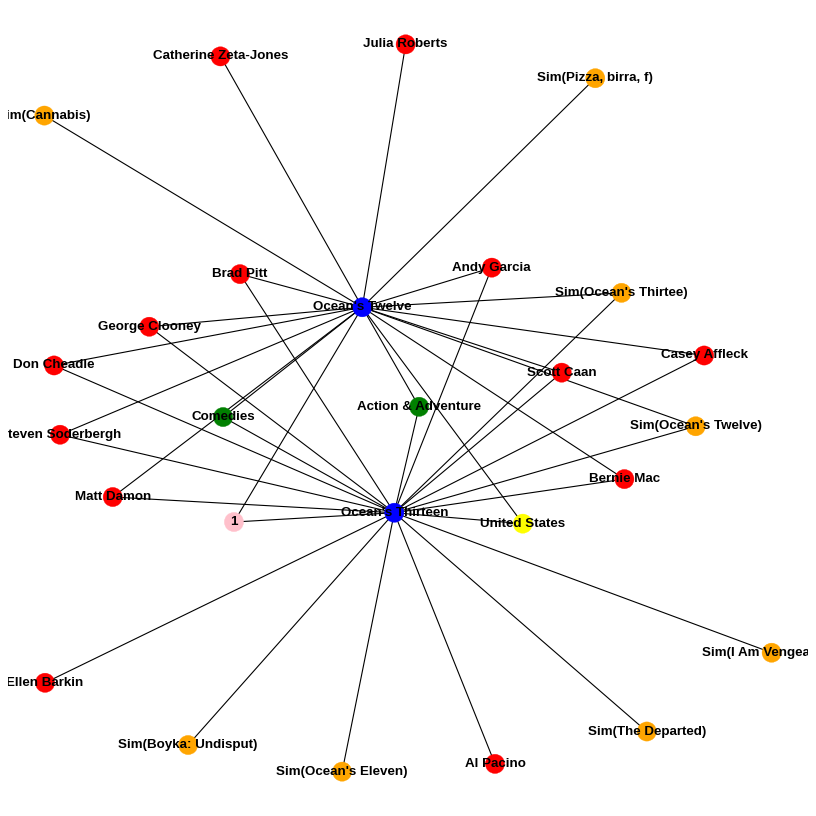

In [ ]:
figure(figsize=(10, 10), dpi=80)
película_1 = "Ocean's Twelve"
película_2 = "Ocean's Thirteen"
list_in = [película_1, película_2]

#
# Seleccionamos los nodos adyacentes
#
sub_graph = get_all_adj_nodes(list_in)

#
# Dibujamos el grafo
#
draw_sub_graph(sub_graph)

Repasamos que contiene un nodo y una relación, en este caso usamos el nodo tipo **película**.

In [ ]:
G.nodes["Ocean's Twelve"]

{'key': 's4566', 'label': 'MOVIE', 'mtype': 'Movie', 'rating': 'PG-13'}

In [ ]:
G.edges[("Ocean's Twelve", "Brad Pitt")]

{'label': 'ACTED_IN'}

Y el caso particular de la similitud entre ambas películas si existe (como es el caso):

In [ ]:
G.edges[("Sim(Ocean's Twelve)","Ocean's Twelve")]

{'label': 'SIMILARITY'}

También mostramos el vecindario de estas dos películas

In [ ]:
sub_graph

[1,
 'Andy Garcia',
 'Casey Affleck',
 'Catherine Zeta-Jones',
 'Sim(Boyka: Undisput)',
 'Brad Pitt',
 "Sim(Ocean's Eleven)",
 'Don Cheadle',
 'Al Pacino',
 'Scott Caan',
 "Sim(Ocean's Thirtee)",
 'Julia Roberts',
 'Action & Adventure',
 "Ocean's Thirteen",
 "Sim(Ocean's Twelve)",
 'Sim(I Am Vengeance:)',
 'Sim(Cannabis)',
 'Steven Soderbergh',
 'United States',
 'Bernie Mac',
 'George Clooney',
 'Comedies',
 'Sim(The Departed)',
 "Ocean's Twelve",
 'Matt Damon',
 'Ellen Barkin',
 'Sim(Pizza, birra, f)']

## La función de recomendación

Construimos una función de recomendación siguiendo una serie de claves:

* Recorremos *el vecindario* de la película de destino → esta es una lista de actor, director, país, categoría
* Recorremos *el vecindario* de cada vecino → descrubrimos las películas que comparten un nodo con el campo objetivo
* Calculo Adamic Adar medida → resultados finales

### La medida Adamic Adar

Es una medida que se utiliza para calcular la proximidad de los nodos en función de sus vecinos compartidos.

* *X* e *Y* son 2 nodos (2 películas)
* *N* (one_node) es una función que devuelve el conjunto de nodos adyacentes a one_node

**pregunta** ¿cómo se llama a la función N(u)?

La función de similitud se define como:

$
     adamicAdar(x,y) = \sum{\frac{1}{log\ N(u) }}
$

Dicho de otra manera, para cada nodo *u* en común con $x$ e $y$, se suma a la medida $1 / log\ N(u)$.

Por tanto esta cantidad sumada determina la importancia de $u$ en la medida. En cierta medida sigue la lógica del tfidf, *las relaciones singulares fortalecen la creencia de que los dos elementos tienen algo en común*.

* si $x$ e $y$ comparten un nodo $u$ que tiene muchos nodos adyacentes, este nodo no es realmente relevante. Por consiguiente si $N(u)$ es alto → $1 / log\ N(u)$ no es alto.
* si $x$ e $y$ comparten un nodo $u$ que no tiene muchos nodos adyacentes, este nodo es realmente relevante. Por consiguiente, si $N(u)$ no es alto → $1 / log\ N(u)$ es mayor.

In [ ]:
#
# Cálculo de recomendaciones para un elemento
# recorremos el grafo dos niveles de profundidad
#
def get_recommendation(root):
    commons_dict = {}
    for e in G.neighbors(root):
        for e2 in G.neighbors(e):
            if e2 == root:
                continue # Evitamos ciclos
            if G.nodes[e2]['label']=="MOVIE":
                commons = commons_dict.get(e2)
                if commons==None:
                    commons_dict.update({e2 : [e]})
                else:
                    commons.append(e)
                    commons_dict.update({e2 : commons})
    movies=[]
    weight=[]
    for key, values in commons_dict.items():
        w=0.0
        for e in values:
            w=w + 1 / math.log(G.degree(e))
        movies.append(key)
        weight.append(w)

    result = pd.Series(data=np.array(weight),index=movies)
    result.sort_values(inplace=True,ascending=False)
    return result;

### Ejemplo

Realizamos alguna prueba con varias películas

In [ ]:
films = ["Ocean's Twelve", "Ocean's Thirteen", "The Devil Inside", "Stranger Things"]
for film in films:
  result = get_recommendation(film)
  print("*"*40+"\n Recomendación para '"+film+"'\n"+"*"*40)
  print(result.head(3))

****************************************
 Recomendación para 'Ocean's Twelve'
****************************************
Ocean's Thirteen    7.147387
Ocean's Eleven      1.642506
The Informant!      1.366729
dtype: float64
****************************************
 Recomendación para 'Ocean's Thirteen'
****************************************
Ocean's Twelve    7.147387
The Departed      2.345845
Ocean's Eleven    2.200617
dtype: float64
****************************************
 Recomendación para 'The Devil Inside'
****************************************
The Boy                                  1.901648
The Devil and Father Amorth              1.578895
Belief: The Possession of Janet Moses    1.281325
dtype: float64
****************************************
 Recomendación para 'Stranger Things'
****************************************
Beyond Stranger Things    12.161730
Rowdy Rathore              2.699173
Big Stone Gap              2.355888
dtype: float64


## Recomendaciones de ejemplo

### Ejemplo Taxi Driver

In [ ]:
film_name = "Taxi Driver"
result_recommendations = get_recommendation(film_name)
print("*"*40+"\n Recomendación para '"+ film_name+ "'\n"+"*"*40)
print(result_recommendations.head())

****************************************
 Recomendación para 'Taxi Driver'
****************************************
Mean Streets                       2.720491
Alice Doesn't Live Here Anymore    2.129170
The Irishman                       1.480716
Raging Bull                        1.375958
Pose                               1.353440
dtype: float64


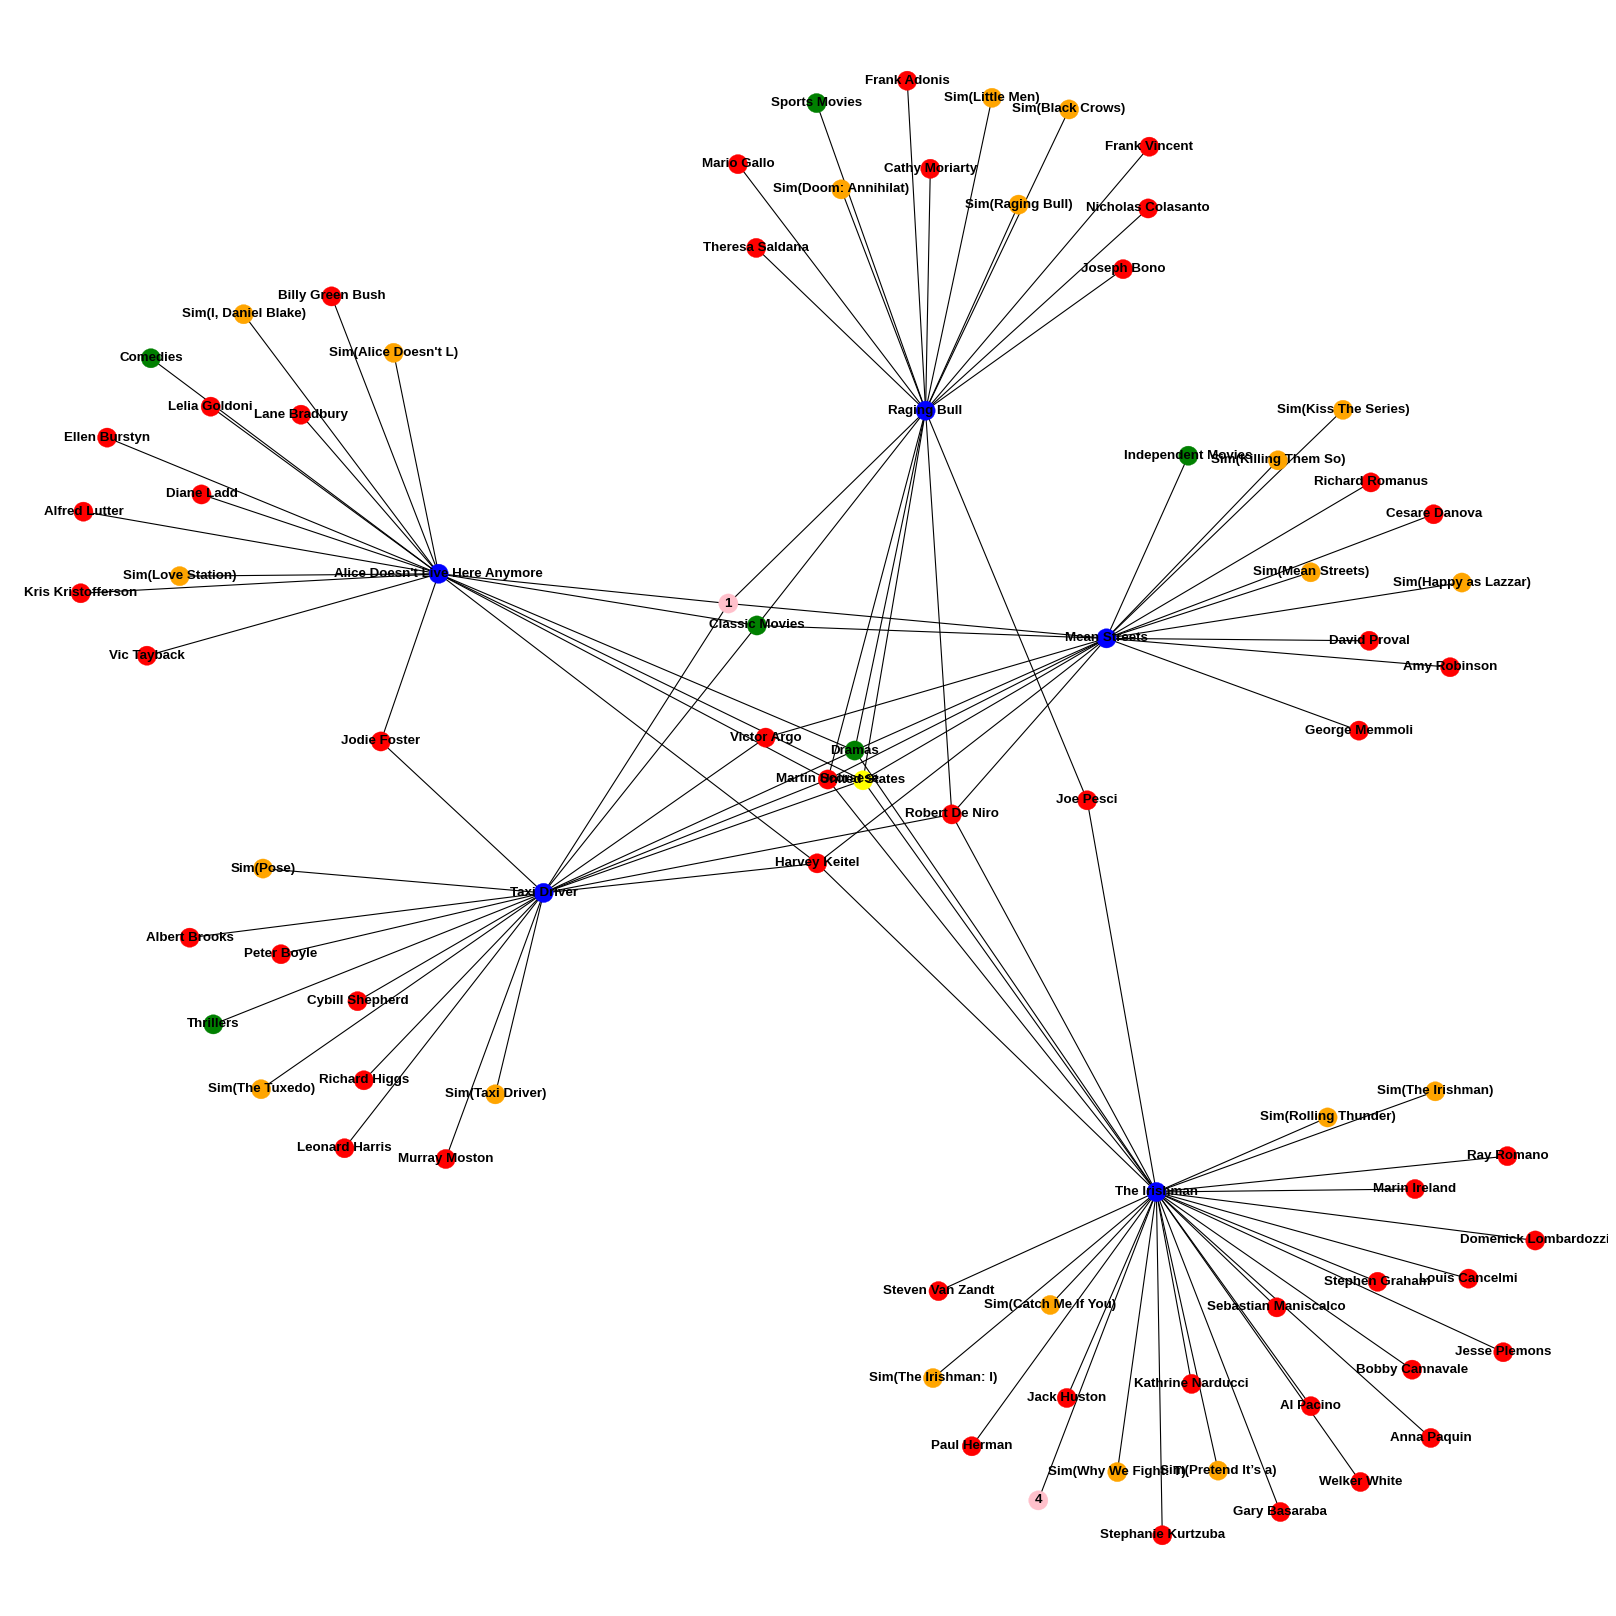

In [ ]:
# Dibujamos el grafo completo
________________________________________________

### Ejemplo Narcos

In [ ]:
film_name = "Narcos"
________________________________________________

****************************************
 Recommendation for 'Narcos'
****************************************
Narcos: Mexico            3.537516
Miss Dynamite             3.480664
Wild District             3.452620
El Chapo                  2.474763
El Cartel 2               2.215907
El señor de los Cielos    2.042999
We Can Be Heroes          1.868806
El Cartel                 1.721021
Perfect Stranger          1.679914
Yankee                    1.593632
dtype: float64


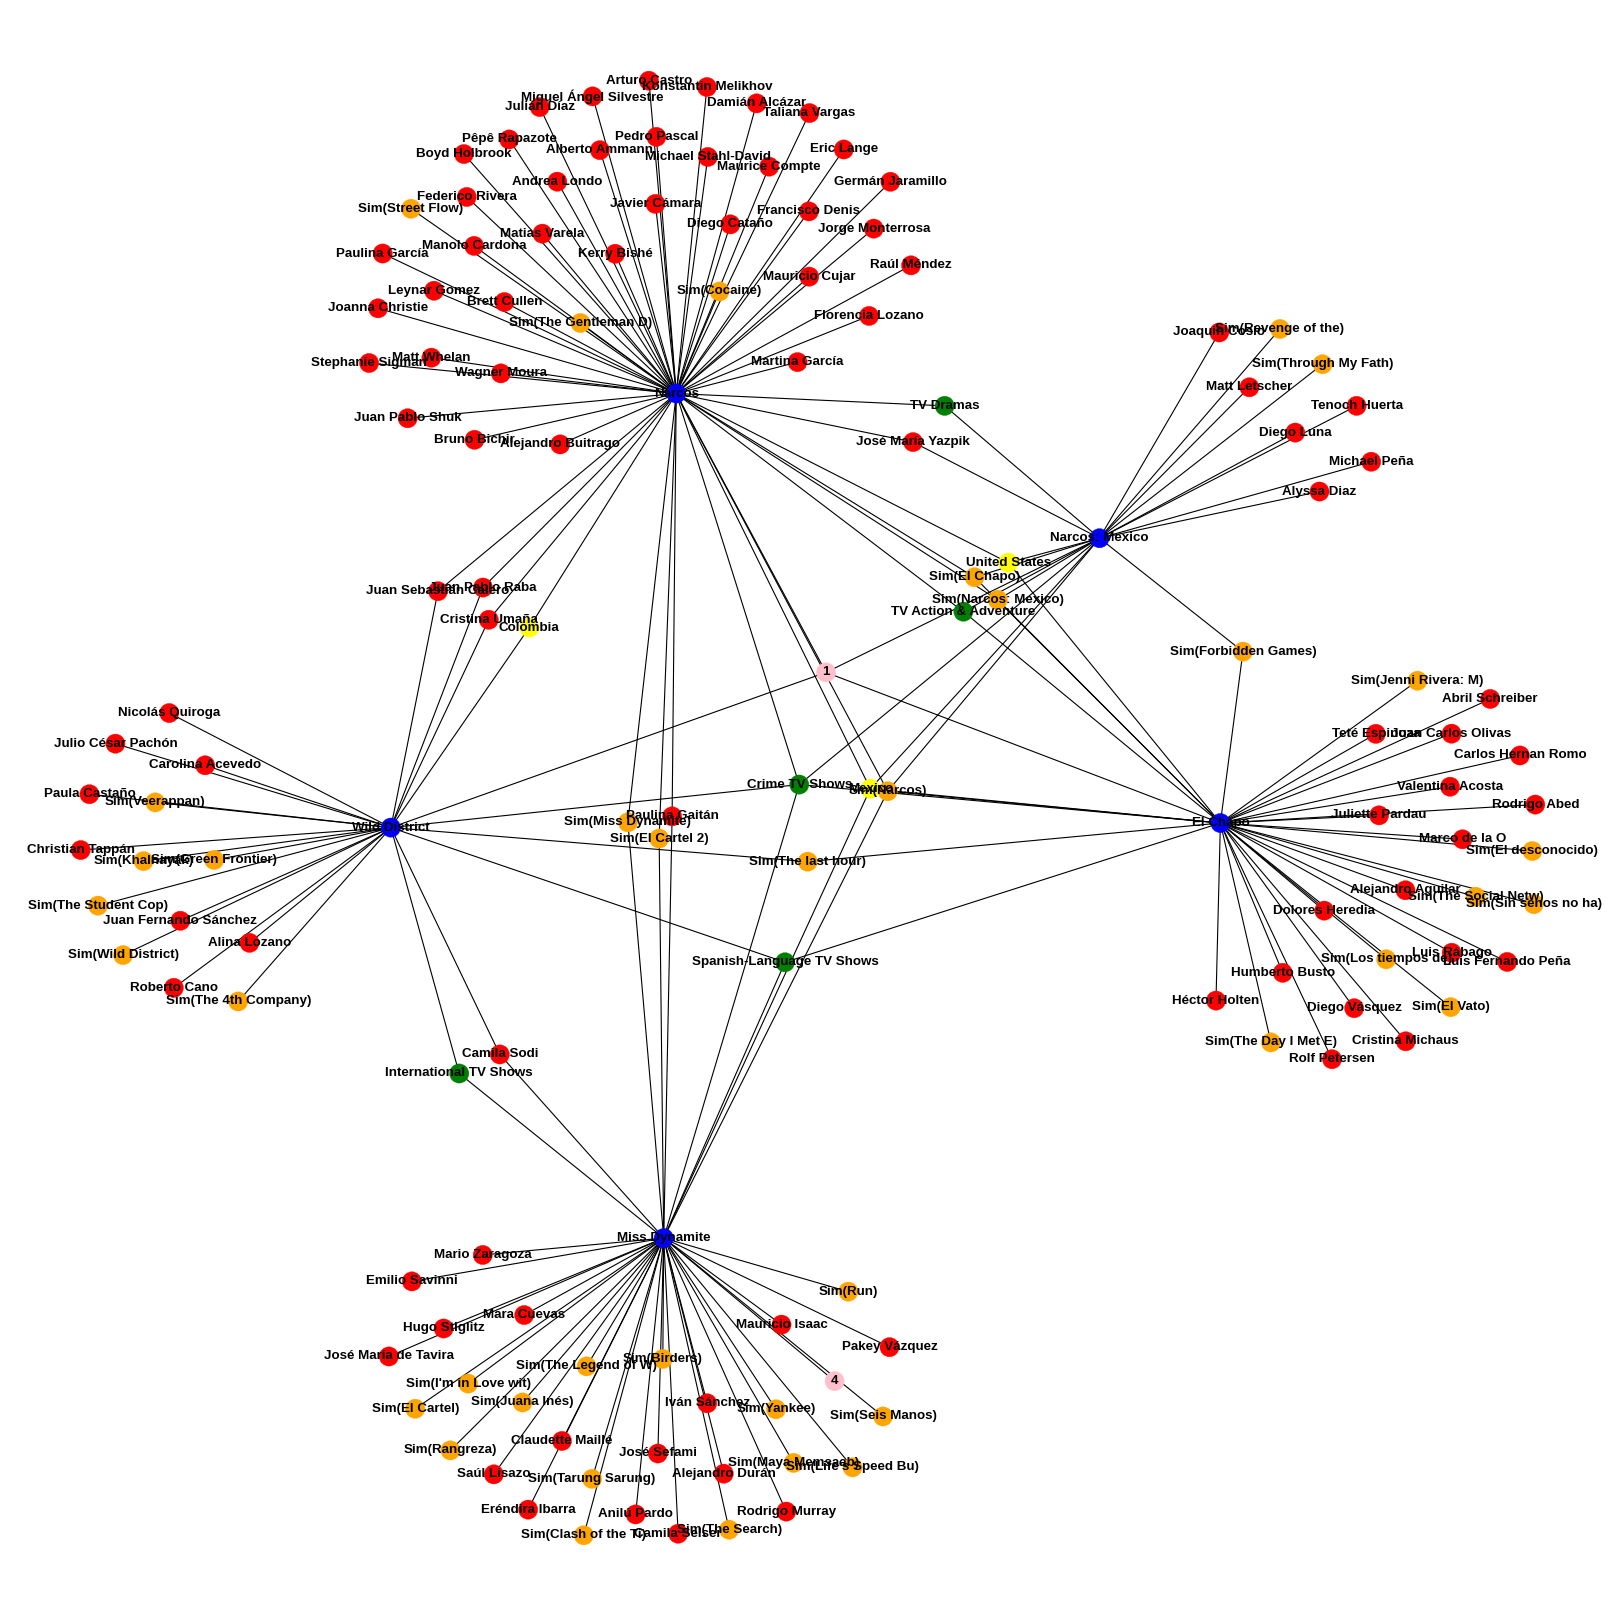

In [ ]:
figure(figsize=(20, 20), dpi=80)

________________________________________________

## Ejercicio - Recomendadores de actores

¿Te atreverías a recomendar actores?, ¿qué actores están relacionados con *Scarlett Johansson* y *Steven Seagal*.

In [ ]:
def get_recommendation_performer(root):
   ________________________________________________
  return result;

In [ ]:
performer = "Scarlett Johansson"
result_recommendations = get_recommendation_performer(actor_name)
print("*"*40+"\n Si te gustó '"+ performer+ "'\n"+"*"*40)
print(result_recommendations.head(10))

****************************************
 Si te gustó 'Scarlett Johansson'
****************************************
Kurt Russell      0.352956
Halle Berry       0.352956
John Leguizamo    0.352956
Oliver Platt      0.352956
Joe Morton        0.352956
David Suchet      0.352956
BD Wong           0.352956
Len Cariou        0.352956
Whip Hubley       0.352956
Stuart Baird      0.352956
dtype: float64


In [ ]:
performer = "Steven Seagal"
result_recommendations = get_recommendation_performer(performer)
print("*"*40+"\n Si te gustó '"+ performer+ "'\n"+"*"*40)
print(result_recommendations.head(10))

****************************************
 Si te gustó 'Steven Seagal'
****************************************
Kurt Russell      0.352956
Halle Berry       0.352956
John Leguizamo    0.352956
Oliver Platt      0.352956
Joe Morton        0.352956
David Suchet      0.352956
BD Wong           0.352956
Len Cariou        0.352956
Whip Hubley       0.352956
Stuart Baird      0.352956
dtype: float64
